# Driver Behavior Dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [18]:
def get_event(seconds_passed, groundTruth):
    for _, row in groundTruth.iterrows():
        if row[' inicio'] <= seconds_passed <= row[' fim']:
            return row['evento']
    return None

In [19]:
def getGroundTruth(df, groundTruth_orig):
    df['seconds_passed'] = (df['timestamp'] - df['timestamp'].iloc[0]).dt.total_seconds() # Converting timestamp to seconds passed
    df['evento'] = df['seconds_passed'].apply(lambda x: get_event(x, groundTruth_orig)) # Getting the event for each row based on seconds passed
    return df


In [20]:
def getData(driver):
    accLinear_orig = pd.read_csv(f'data/{driver}/aceleracaoLinear_terra.csv')
    acelerometro_orig = pd.read_csv(f'data/{driver}/acelerometro_terra.csv')
    giroscopio_orig = pd.read_csv(f'data/{driver}/giroscopio_terra.csv')
    groundTruth_orig = pd.read_csv(f'data/{driver}/groundTruth.csv')

    # Renaming columns to avoid conflicts
    accLinear = accLinear_orig.rename(columns={'x': 'x_accLinear', 'y': 'y_accLinear', 'z': 'z_accLinear'}, inplace=False) 
    acelerometro = acelerometro_orig.rename(columns={'x': 'x_acelerometro', 'y': 'y_acelerometro', 'z': 'z_acelerometro'}, inplace=False) 
    giroscopio = giroscopio_orig.rename(columns={'x': 'x_giroscopio', 'y': 'y_giroscopio', 'z': 'z_giroscopio'}, inplace=False)

    # Merging all dataframes
    df = pd.concat([accLinear, acelerometro, giroscopio], axis=1)
    df = df.loc[:, ~df.columns.duplicated()]

    # Converting timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'], format='%d/%m/%Y %H:%M:%S')
    # Getting the event for each row based on seconds passed
    df = getGroundTruth(df, groundTruth_orig)

    return df

In [94]:
df = getData(17)

Plotting different sensors to see the difference

In [27]:
normal = df[(df['seconds_passed'] >= 8) & (df['seconds_passed'] <= 12)]
curva_direita = df[(df['seconds_passed'] >= 20) & (df['seconds_passed'] <= 24)]

In [117]:
def plot_single_sensor(data, sensor, figsize=(10, 4), begin=None, end=None):
    plt.plot(data['seconds_passed'], data[f'x_{sensor}'], label=f'x_{sensor}')
    plt.plot(data['seconds_passed'], data[f'y_{sensor}'], label=f'y_{sensor}')
    plt.plot(data['seconds_passed'], data[f'z_{sensor}'], label=f'z_{sensor}')
    for i in range(len(data) - 1):
        if data['evento'].iloc[i] is not None:
            plt.axvspan(data['uptimeNanos'].iloc[i], data['uptimeNanos'].iloc[i + 1], alpha=0.3, edgecolor='none')
            if i == 0 or data['evento'].iloc[i] != data['evento'].iloc[i - 1]:
                plt.text((data['uptimeNanos'].iloc[i] + data['uptimeNanos'].iloc[i + 1]) / 2, 
                        max(data[f'x_{sensor}'].max(), data[f'y_{sensor}'].max(), data[f'z_{sensor}'].max()), 
                        data['evento'].iloc[i], 
                        horizontalalignment='left', 
                        verticalalignment='top', 
                        fontsize=12, 
                        color='black', 
                        rotation=0)


In [118]:
def plot_multiple_sensors(data, sensors, figsize=(10, 4), begin=None, end=None):
    for sensor in sensors:
        plt.figure(figsize=figsize)
        plot_single_sensor(data, sensor, figsize, begin, end)
        plt.title(sensor)
        plt.legend()
        plt.show()

In [121]:
def plot_sensor_data(data, sensor=None, figsize=(10, 4), begin=None, end=None):

    if begin is not None:
        data = data[data['seconds_passed'] >= begin]
        if end < begin:
            raise ValueError('End must be greater than begin')

    if end is not None:
        data = data[data['seconds_passed'] <= end]

    if sensor is None:
        sensor = ['acelerometro', 'accLinear', 'giroscopio']
        
    plt.figure(figsize=figsize)
    plt.plot(data['uptimeNanos'], data[f'x_{sensor}'], label=f'x_{sensor}')
    plt.plot(data['uptimeNanos'], data[f'y_{sensor}'], label=f'y_{sensor}')
    plt.plot(data['uptimeNanos'], data[f'z_{sensor}'], label=f'z_{sensor}')
    
    # Highlight regions where 'evento' is not None
    for i in range(len(data) - 1):
        if data['evento'].iloc[i] is not None:
            plt.axvspan(data['uptimeNanos'].iloc[i], data['uptimeNanos'].iloc[i + 1], alpha=0.3, edgecolor='none')
            if i == 0 or data['evento'].iloc[i] != data['evento'].iloc[i - 1]:
                plt.text((data['uptimeNanos'].iloc[i] + data['uptimeNanos'].iloc[i + 1]) / 2, 
                         max(data[f'x_{sensor}'].max(), data[f'y_{sensor}'].max(), data[f'z_{sensor}'].max()), 
                         data['evento'].iloc[i], 
                         horizontalalignment='left', 
                         verticalalignment='top', 
                         fontsize=12, 
                         color='black', 
                         rotation=0)

    plt.xlabel('uptimeNanos')
    plt.ylabel(sensor.capitalize())
    plt.legend()
    plt.show()

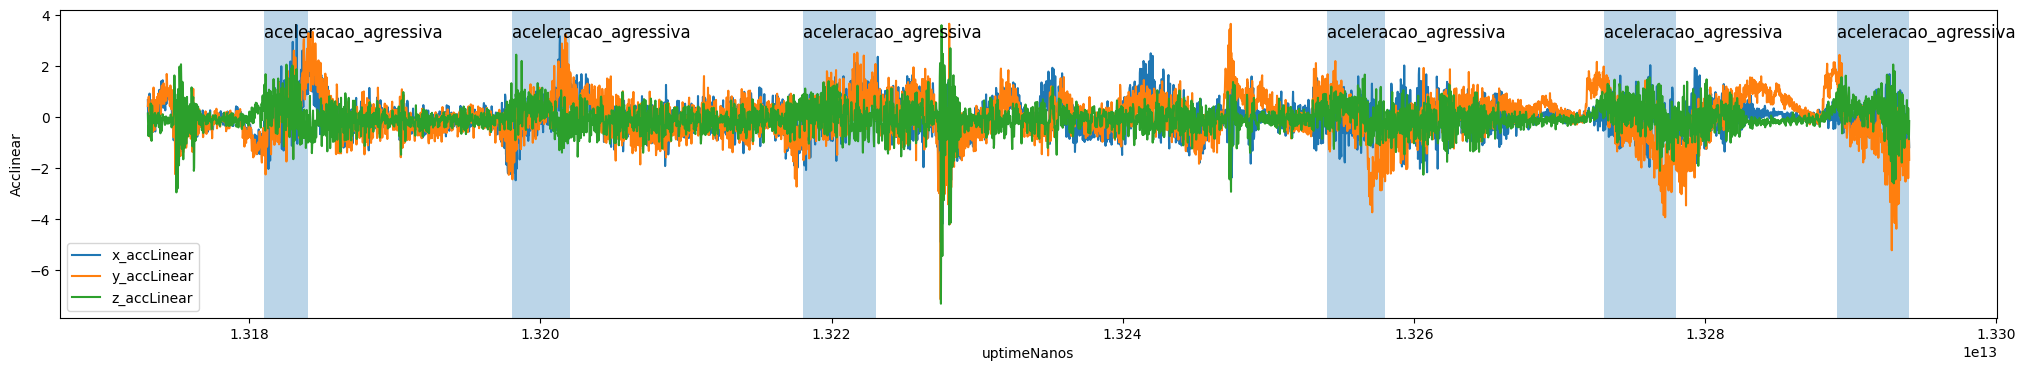

In [122]:
plot_sensor_data(df, 'accLinear', figsize=(25, 4), begin=280, end=400)